Installing and importing modules

In [89]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [90]:
!pip install -U --no-cache-dir gdown --pre

In [91]:
import os
import cv2 # preprocessing data
import tensorflow as tf # training model
import numpy as np # data manipulation
from typing import List
from matplotlib import pyplot as plt # post processing ploting
import imageio # numpy => GIF

In [92]:
# limit memory to prevent data leak
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
  

Data Loading Functions

In [93]:
import gdown

In [94]:
url = 'https://drive.google.com/u/0/uc?id=1o0RsN-LQsu703DIu0o-aw3Uh9SRpBz_6&export=download'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From: https://drive.google.com/u/0/uc?id=1o0RsN-LQsu703DIu0o-aw3Uh9SRpBz_6&export=download
To: /kaggle/working/data.zip
100%|██████████| 423M/423M [00:02<00:00, 209MB/s]  


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [95]:
def load_video(path:str) -> List[float]:
  cap = cv2.VideoCapture(path)
  frames = []
  for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret,frame = cap.read()
    frame = tf.image.rgb_to_grayscale(frame)
    frames.append(frame[190:236,80:220,:])
    # selecting the lip area from the whole image statically
  cap.release()
  # standadizing the images
  mean = tf.math.reduce_mean(frames)
  std = tf.math.reduce_std(tf.cast(frames,tf.float32))
  return tf.cast((frames - mean),tf.float32) /std 


In [96]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [97]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [98]:
# converting char to num inorder to tokenize the dataset
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab,oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),oov_token="",invert=True
)
print(f"The vocabulary is : {char_to_num.get_vocabulary()}\n"
      f"(size = {char_to_num.vocabulary_size()}")


The vocabulary is : ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ']
(size = 40


In [99]:
char_to_num(["a","b","d"]) # encoding it to [1,2,4]

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 2, 4])>

In [100]:
num_to_char([1,2,4]) # decoding it back to a,b,d

<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'a', b'b', b'd'], dtype=object)>

In [101]:
def load_alignments(path:str) -> List[str]: 
#     print(path)
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [102]:
def load_data(path: str): 
  path = bytes.decode(path.numpy())
  file_name = path.split('/')[-1].split(".")[0]
  # file_name = tf.convert_to_tensor(path).numpy().decode('utf-8').split("\\")[-1].split('.')[0]
  
  video_path = os.path.join('data','s1',f"{file_name}.mpg")
  alignment_path = os.path.join("data","alignments",'s1',f"{file_name}.align")
  # print(file_name,alignment_path)
  frames = load_video(video_path)
  alignments = load_alignments(alignment_path)
  
  return frames,alignments

In [103]:
test_path = './data/s1/bbal6n.mpg'

In [104]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split("\\")[-1].split('.')[0]

''

In [105]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

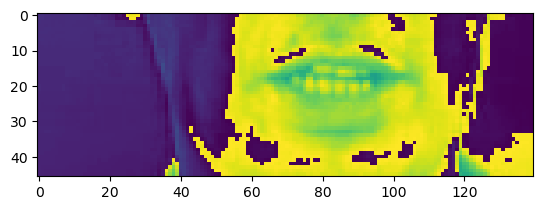

In [106]:
frame = frames[40].numpy().squeeze()
plt.imshow(frame);

In [107]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [108]:
# wrapper used for string input data pipelines
def mappable_function(path:str) -> List[str]:
  result = tf.py_function(load_data,[path],(tf.float32,tf.int64))
  return result

Create Data Pipeline






In [109]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500,reshuffle_each_iteration=False)
data = data.map(mappable_function)
# padding alignments to 40
data = data.padded_batch(2,padded_shapes=([75,None,None,None],[40])) 
data = data.prefetch(tf.data.AUTOTUNE)

In [110]:
len(frames)

75

In [111]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [112]:
test = data.as_numpy_iterator()

In [113]:
val = test.next(); val[0]

array([[[[[1.3135941 ],
          [1.3511254 ],
          [1.4261879 ],
          ...,
          [0.33778134],
          [0.30025008],
          [0.30025008]],

         [[1.2760628 ],
          [1.3511254 ],
          [1.3886566 ],
          ...,
          [0.33778134],
          [0.30025008],
          [0.30025008]],

         [[1.5012505 ],
          [1.5012505 ],
          [1.4637191 ],
          ...,
          [0.33778134],
          [0.30025008],
          [0.30025008]],

         ...,

         [[1.0508753 ],
          [1.013344  ],
          [1.013344  ],
          ...,
          [0.07506252],
          [0.03753126],
          [0.03753126]],

         [[1.013344  ],
          [1.013344  ],
          [1.013344  ],
          ...,
          [0.07506252],
          [0.03753126],
          [0.03753126]],

         [[1.013344  ],
          [1.013344  ],
          [1.013344  ],
          ...,
          [0.07506252],
          [0.03753126],
          [0.        ]]],


        [[[1.3511

In [114]:
imageio.mimsave('./animation.gif',val[0][0],fps=10)

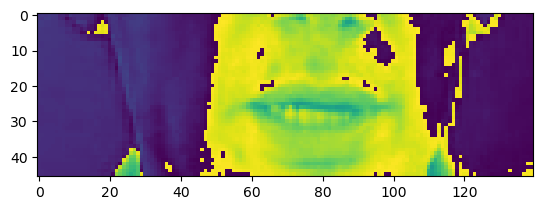

In [115]:
plt.imshow(val[0][1][35].squeeze());

In [116]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay red by r seven again'>

Design the Deep Neural Network

In [117]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [118]:
model = Sequential()
model.add(Conv3D(128,3,input_shape=(75,46,140,1),padding='same')) # padding = same means ouput shape is preserved
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256,3,padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75,3,padding="same"))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten())) # 75 inputs and 75 outputs


model.add(Bidirectional(LSTM(128,kernel_initializer="Orthogonal",return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128,kernel_initializer="Orthogonal",return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1,kernel_initializer="he_normal",activation='softmax'))

In [119]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 75, 46, 140, 128)  3584      
                                                                 
 activation_6 (Activation)   (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 75, 23, 70, 128)  0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_7 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                  

In [120]:
5*17*75

6375

In [121]:
yhat = model.predict(val[0])
# prediction before training 

1/1 [==============================] - 7s 7s/step


In [122]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[1]])

<tf.Tensor: shape=(), dtype=string, numpy=b'4444444444444444444444444444444444444444444444444444444444444444444444444??'>

In [123]:
model.input_shape

(None, 75, 46, 140, 1)

In [124]:
model.output_shape

(None, 75, 41)

Setup Training options and Train

In [125]:
# Taken from Automatic Speech recognision model
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [126]:
def scheduler(epoch,lr):
  if epoch<30:
    return lr
  else:
    return lr* tf.math.exp(-0.1)

In [127]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('-'*100)

In [128]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss=CTCLoss)

In [129]:
checkpoint_callback = ModelCheckpoint(os.path.join("models","checkpoint"),monitor="loss",save_weights_only=True)

In [130]:
schedule_callback = LearningRateScheduler(scheduler)

In [131]:
# Added for split 
train = data.take(450)
test = data.skip(450)
example_callback = ProduceExample(test)

In [132]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback, example_callback])


Epoch 1/5
  3/450 [..............................] - ETA: 6:06:33 - loss: 170.1835

KeyboardInterrupt: 

In [ ]:
# https://www.youtube.com/watch?v=uKyojQjbx4c